Cacophony for the whole family
==============================

Allen Downey

This is an example that demonstrates some of the features in the *Think DSP* library.

It is inspired by the performance of a grade school band I witnessed recently.  My goal is to simulate the sound of a beginner band.


In [1]:
# Get thinkdsp.py

import os

if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/AllenDowney/ThinkDSP/raw/master/code/thinkdsp.py

In [2]:
from thinkdsp import *

In [3]:
from scipy.ndimage import gaussian_filter1d
import numpy as np

# How to make letter S

First, I study the recording of letter S.

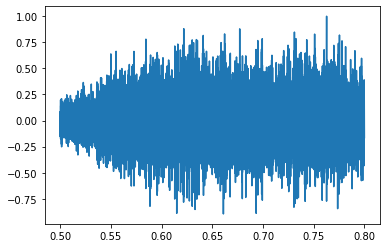

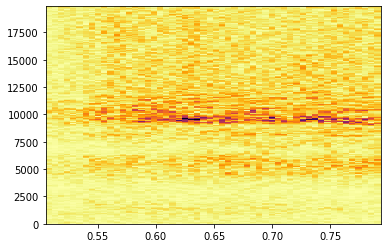

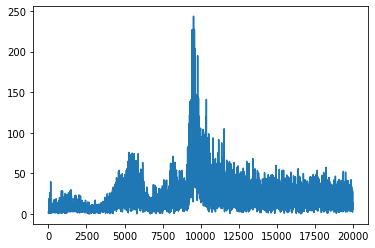

In [4]:
wave = read_wave('/home/ummagumma/Downloads/ssss.wav')
wave = wave.segment(start=0.5, duration=0.3)

wave.plot()
plt.show()
wave.make_spectrogram(512).plot(high=20000)
plt.show()
spectrum = wave.make_spectrum()
spectrum.plot(high=20000)
plt.show()

wave.make_audio()

I see a peek of amplitude at frequency ~9000. If I apply a high-pass filter and leave only frequencies >9000, the audio still sounds like an S letter.

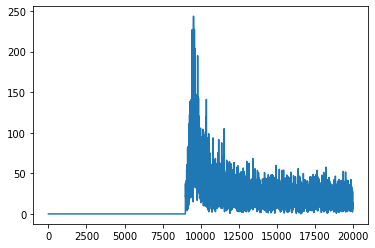

In [5]:
spectrum = wave.make_spectrum()
spectrum.high_pass(9000)
spectrum.plot(high=20000)
spectrum.make_wave().make_audio()

Another observation is that amplitudes for frequencies >9000 declines like an exponential with carefully tweaked parameters.

/home/ummagumma/miniconda3/envs/vtkenv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


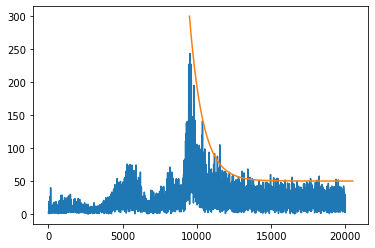

In [6]:
spectrum = wave.make_spectrum()
spectrum.plot(high=20000)
ys = 250 / np.arange(11000)
ys = 250 * np.exp(-np.arange(11000)/900) + 50
plt.plot(np.arange(9500, 20500), ys)
plt.show()

So the idea then is to generate a random noise and to change its spectrum such that it looks like the spectrum of recorded letter S. And then to transform it back.

In [7]:
def get_letter_s():
    signal = UncorrelatedUniformNoise()
    wave = signal.make_wave(duration=1, framerate=40000)

    spectrum = wave.make_spectrum()
    ys = 250 * np.exp(-np.arange(11000)/900) + 50
    ys = np.hstack((np.zeros(len(spectrum) - len(ys)), ys))
    spectrum.hs *= ys
    spectrum.hs /= (spectrum.hs.max() / 250)
    wave = spectrum.make_wave().segment(0, 0.2)
    wave.apodize()
    
    return wave

# How to generate letter A
Since letter A is a vowel, it should have formants - frequencies with high amplitudes that define the vowel. So my idea is to generate a signal with some predefined fundamental frequency and its harmonics, and to change its spectrogram such that it resembles spectrogram of the letter A.

To change a spectrogram, I design a filter which emphasizes formant frequencies. An example is below:

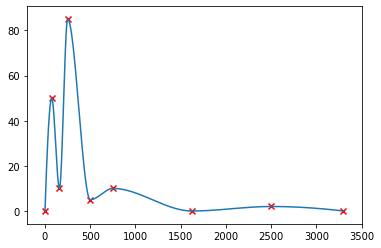

In [8]:
from scipy.interpolate import PchipInterpolator, CubicSpline
bxs = [0, 75, 160, 250, 500, 750, 1625.0, 2500, 3300]
bys = [0, 50, 10, 85,  5, 10,  0, 2, 0]
def formant_filter(bxs, bys):
    cs = PchipInterpolator(bxs, bys)
    xs = np.arange(0, 3300)
    
    return xs, cs(xs)

xs, ys = formant_filter(bxs, bys)
plt.plot(xs, ys)
plt.scatter(bxs, bys, marker='x', color='r')
plt.show()

In [9]:
import sys
sys.setrecursionlimit(100000)

def harmonical_signal(f0):
    
    margin = 20
    mix = SinSignal(freq=f0, amp=0, offset=0)
    for freq in np.arange(f0, 50*f0, f0):
        mix += SinSignal(freq=freq, amp=10, offset=0)
        mix += CosSignal(freq=freq, amp=10, offset=0)
        mix += SquareSignal(freq=freq, amp=30, offset=0)

    framerate = 40000
    duration = 100 / f0
    wave = mix.make_wave(duration=duration, framerate=framerate)
    wave.normalize()
    return wave   

def get_letter(formants, amps, dur, f0=75):
    wave = harmonical_signal(f0)

    spectrum = wave.make_spectrum()

    xs, ys = formant_filter(formants, amps)

    ys = np.hstack((ys, np.zeros(len(spectrum) - len(ys))))

    spectrum.hs *= ys
    spectrum.hs /= (np.abs(spectrum.hs).max() / 250)

    wave = spectrum.make_wave().segment(0, dur / f0)
    wave.normalize()
    return wave

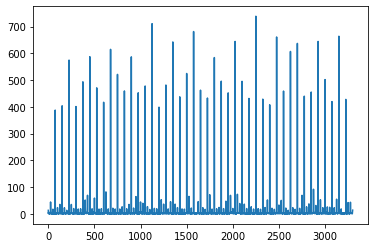

In [10]:
wave = harmonical_signal(75)
wave.make_spectrum().plot(high=3300)
plt.show()

# How to generate L and V
We can obtain L and V by a crude approximation using formants. I found formant frequencies for these letters here: http://www.asel.udel.edu/speech/tutorials/synthesis/cons1.html

Then, all I need to do is to provide formant-generation function with appropriate parameters for each letter:

In [11]:
def get_letter_l(dur):
    return get_letter([0, 75, 260, 550, 800, 1150, 1875, 2700, 3300], [0, 25, 15, 60, 5, 20,  1, 5, 0], dur)

def get_letter_a(dur):
    return get_letter([0, 75, 350, 800, 975, 1150, 2025.0, 2900, 3300], [0, 50, 10, 60,  30, 56,  10, 52, 0], dur)

def get_letter_v(dur):
    return get_letter([0, 500, 750, 1000, 1325, 2700, 3300], [10, 85, 35, 30, 1, 10, 0], dur)

For a smoother transition between letters, I interpolate between the end and beginning of neighboring waves. Moreover, I apply a gaussian smoothing for even more pleasant sound.

In [12]:
def make_filling(wave1, wave2, filling_time_interval=300, w=0.5):
    o = 300
    p1, p2 = wave1.ys[-o:], wave2.ys[:o]
    times = np.hstack((np.arange(o), np.arange(o + filling_time_interval, filling_time_interval + 2 * o)))
    ys = np.hstack((p1, p2))

    interpol = CubicSpline(times, ys)
    xs = np.arange(filling_time_interval)
    
    filling = interpol(xs)
    filling += np.random.randn(len(filling)) / 100

    filling = Wave(filling, framerate=wave1.framerate)
    return filling

def merge_waves(waves):
    total_wave = waves[0]
    
    for wave in waves[1:]:
        total_wave |= (make_filling(total_wave, wave) | wave)
        
    return total_wave

In [14]:
wave_l.ys.shape

(2667,)

In [13]:
wave_s = get_letter_s()
wave_l = get_letter_l(5)
wave_a = get_letter_a(10)
wave_v = get_letter_v(5)

wave = merge_waves([wave_l, wave_a | wave_a, wave_v, wave_a | wave_a])
wave.ys = gaussian_filter1d(wave.ys, 7.)
wave = merge_waves([wave_s, wave])
wave.apodize()
wave.make_audio()

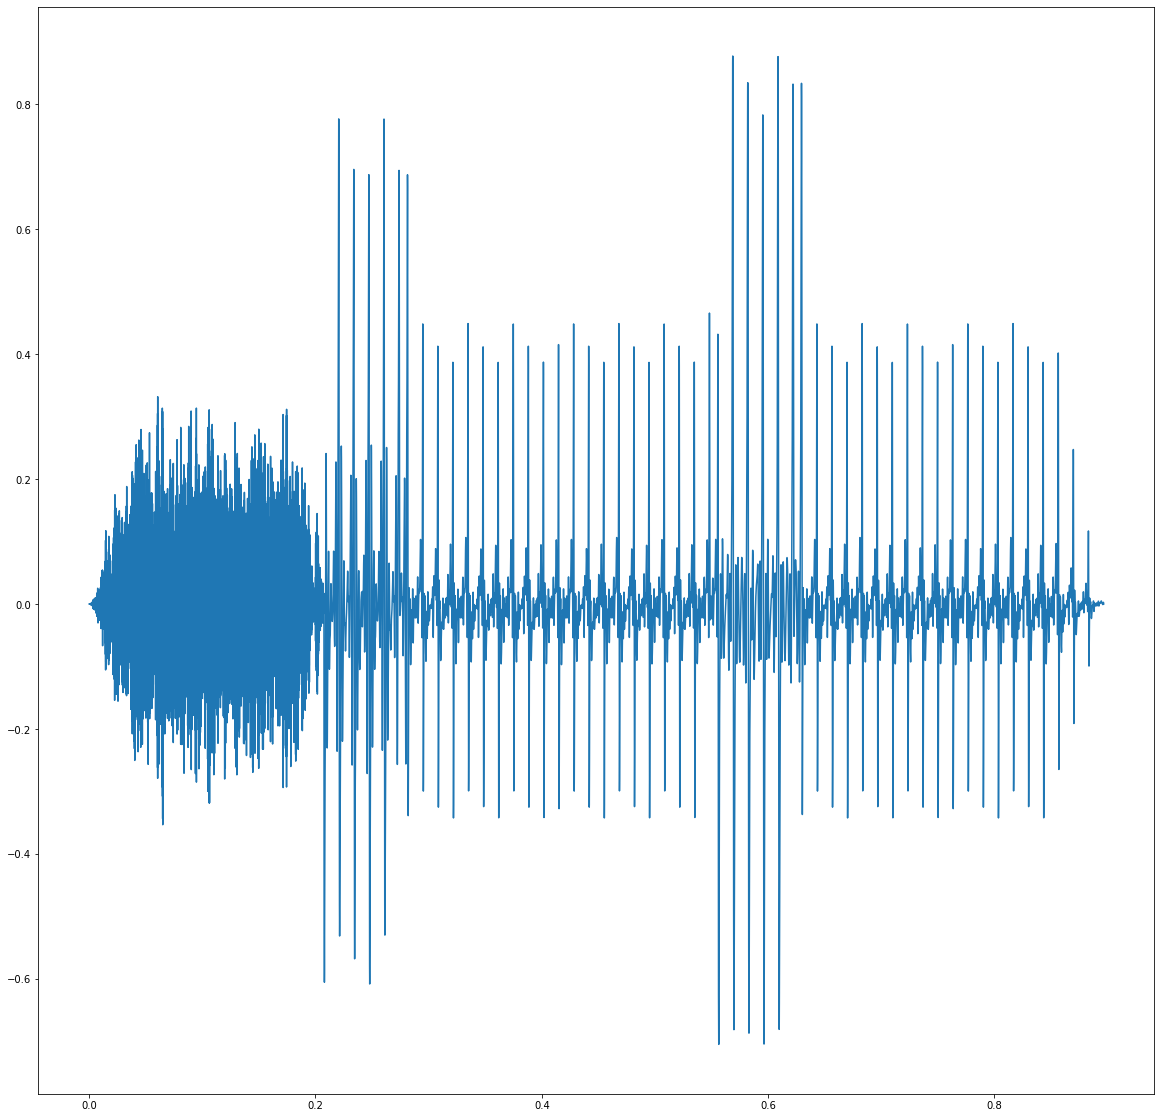

In [14]:
plt.figure(figsize=(20, 20))
wave.plot()
plt.show()

In [15]:
wfw = WavFileWriter(filename='s.wav', framerate=40000)
wfw.write(wave_s)

wfw = WavFileWriter(filename='l.wav', framerate=40000)
wfw.write(wave_l)

wfw = WavFileWriter(filename='a.wav', framerate=40000)
wfw.write(wave_a)

wfw = WavFileWriter(filename='v.wav', framerate=40000)
wfw.write(wave_v)

wfw = WavFileWriter(filename='slava.wav', framerate=40000)
wfw.write(wave)